<a href="https://colab.research.google.com/github/Nakul24-1/Viz-for-ML/blob/main/Surrogate_Models/hw5_np2455.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 5
The main goal of this homework is to use what we have learned from white-box models to understand a black-box model's behavior.

We are still going to use the loan application dataset as in the practice 2. Find it here: https://drive.google.com/file/d/186LjbAZoMat91ByH7aJGJ8PnfO2LqKlu/view?usp=sharing

Don't forget to specify the filepath on your own Google Drive below.


You will need to finish the following subtasks:
- (1) Train a surrogate tree-based model to understand the model prediction behaviors of the provided SVM model. 
- (2) Answer a few questions based on the interpretation of the surrogate model.


In [ ]:
import numpy as np
import pandas as pd
from sklearn import svm


In the column of "Outcome",
- 0 represents "will not default",
- 1 represents "will default".

In [ ]:
df = pd.read_csv(filepath_or_buffer="https://raw.githubusercontent.com/Nakul24-1/Viz-for-ML/main/cleaned_fico_data.csv",)
df

,Outcome,External Risk Estimate,Months Since Oldest Trade Open,Months Since Last Trade Open,Average Months in File,Satisfactory Trades,Trades 60+ Ever,Trades 90+ Ever,Bills Paid on Time,Months Since Last Delq.,Max Delq. Last 12M,Max Delq. Ever,Total Trades,Trades Open Last 12M,% Installment Trades,Months Since Most Recent Inq,Inq Last 6 Months,Inq Last 6 Months exl. 7 days,Unpaid Balance,Installment Burden,Revolving Trades w/ Balance,Installment Trades w/ Balance,Bank Trades w/ High Utilization Ratio,% Trades w/ Balance
0,0,55,144,4,84,20,3,0,83,2,5,5,23,1,43,0,0,0,33,77,8,1,1,69
1,0,61,58,15,41,2,4,4,100,150,2,7,7,0,67,0,0,0,0,57,0,2,0,0
2,0,67,66,5,24,9,0,0,100,150,7,7,9,4,44,0,4,4,53,66,4,2,1,86
3,0,66,169,1,73,28,1,1,93,76,1,6,30,3,57,0,5,4,72,83,6,4,3,91
4,0,81,333,27,132,12,0,0,100,150,7,7,12,0,25,0,1,1,51,89,3,1,0,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9866,1,73,131,5,57,21,0,0,95,80,1,6,21,5,19,7,0,0,26,81,5,2,0,100
9867,0,65,147,39,68,11,0,0,92,28,1,6,12,0,42,1,1,1,86,53,2,2,1,80
9868,0,74,129,6,64,18,1,1,100,150,1,7,18,1,33,3,4,4,6,53,5,3,0,56
9869,0,72,234,12,113,42,2,2,96,35,1,2,45,0,20,6,0,0,19,47,4,1,0,38


In [ ]:
X = df.drop(columns=['Outcome']).values
y = df['Outcome'].values

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
'''train a decision tree model'''
clf = svm.SVC(kernel="linear", C=0.001, probability=True)
clf.fit(X_train, y_train)

SVC(C=0.001, kernel='linear', probability=True)

In [ ]:
print("training accuracy:", clf.score(X_train, y_train))
print("testing accuracy:", clf.score(X_test, y_test))


training accuracy: 0.7310030395136778
testing accuracy: 0.7281012658227848


In [ ]:
Y_svm = clf.predict(X_test)

## Please train a surrogate model to approximate the original model's behavior on the **test set**?

How can we do that?

We can use the original model input (`X_test`), and the model output (but not the labels/ground truth) to train an interpretable surrogate model, for example, a decision tree, or a rule set.


Please include your surrogate model training code below. You can add or remove any code blocks.

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pylab as plt
from sklearn import datasets, ensemble, model_selection
from sklearn.ensemble import RandomForestClassifier

In [ ]:
cls_t = tree.DecisionTreeClassifier()
cls_t.fit(X_test, Y_svm);
cls_t.score(X_test,Y_svm)

1.0

In [ ]:
cls_t = tree.DecisionTreeClassifier(min_samples_leaf = 2)
cls_t.fit(X_test, Y_svm);

In [ ]:
cls_t.score(X_test,Y_svm)

0.9878481012658228

In [ ]:
# Restricting Depth to 4 

cls_t = tree.DecisionTreeClassifier(max_depth = 4,min_samples_leaf = 2)
cls_t.fit(X_test, Y_svm);
cls_t.score(X_test,Y_svm)

0.9346835443037975

In [ ]:
features = df.drop(columns=['Outcome'])
features = features.columns

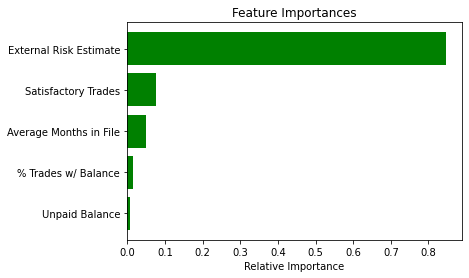

In [ ]:
importances = cls_t.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
j = 5 # top j importance
plt.barh(range(j), importances[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Relative Importance')
plt.show()

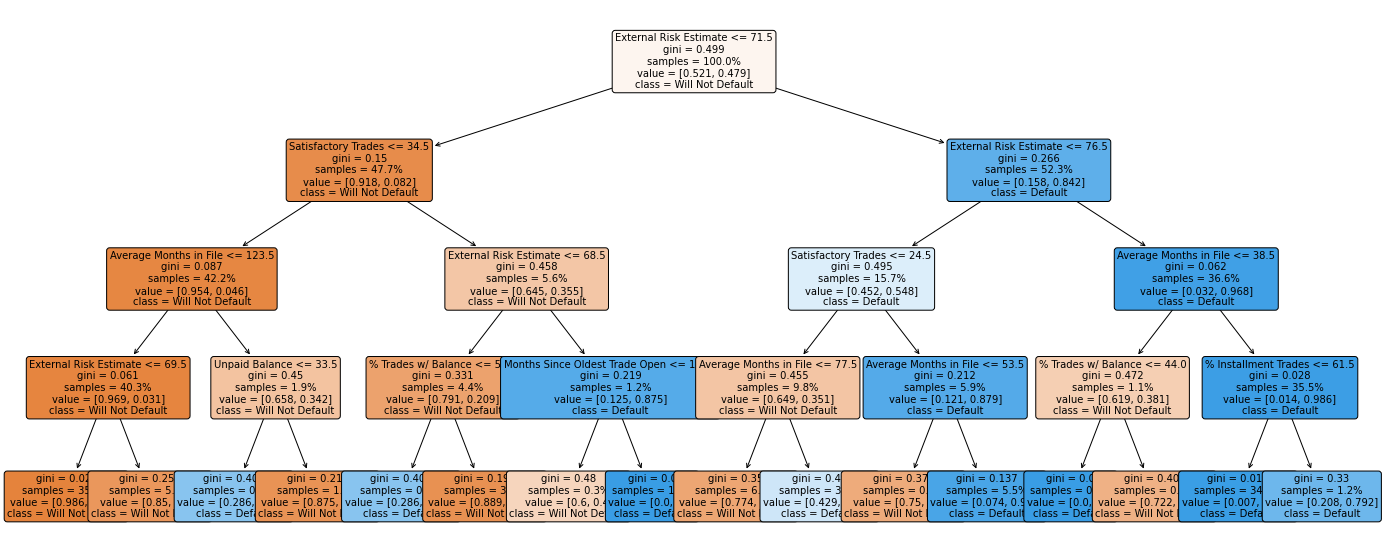

In [ ]:
fig = plt.figure(figsize=(24, 10))
vis = tree.plot_tree(cls_t, feature_names = features, class_names = ['Will Not Default', 'Default'], max_depth=4, fontsize=10, proportion=True, filled=True, rounded=True)

## Question Answering
Please answer the following questions based on the surrogate model you have trained.  

(1) What features are important when the original model makes predictions? List the top 5 features that yout think are mostly important. What's your reason?

(2) Please explain why you choose the parameters you used to train the surrogate tree.

(3) When a person is predicted as "will default" in the future, what may the loan application look like? Describe the application using no more than 3 features. And what's your reason for this description?

(4) Imagine that you are going to deploy this SVM model for the actual business department, please list 3 questions about this SVM model's behavior that you want to know before the actual deployment, and whether they can be answered by the surrogate tree. 
(Notice: This question is not to judege how well you can do something, just to help you understand the role of model interpretation in the whole pipeline. So you can just list whatever you want to talk about.)




======== You can run some code and answer the questions based on what you see from the result ========

### Top 5 Features by Observation - 

1. External Risk Estimate

2. Satisfactory Trades

3. Average Months in File 

4. Unpaid Balance

5. Months Since Oldest Trade Open

These are selected via observing the tree, the 1st split is based on External Risk Estimate so I can assume it is most important.

In the next level Satisfactory Trades was used to determine so it was added to the top 5 list.

Similarly Average Months in File was added in the the next lvl.

In the next lvl we see 3 new features - % Trade w/ Balance, , Unpaid Balance, Months Since original Trade open

I chose Unpaid Balance and Months Since Oldest Trade Open. This decision was based on the gini value, the highest 2 values were chosen.



## Please explain why you choose the parameters you used to train the surrogate tree.

When we take all default parameters we get accuracy of 100 percent which is ideal, but that has a very high chance of overfitting and its difficult to interpret.

When Restricting depth to 4 we get a respectable 93 percent accuracy and the most important features don't change by a lot, just minor shuffling occours.

The min number of leaves was also restricted to 2 to reduce overfitting of a noisy or exceptional data element.

Others were left at default values cause the tree was working as expected without need for a further change

### When a person is predicted as "will default" in the future, what may the loan application look like? Describe the application using no more than 3 features. And what's your reason for this description?


In [ ]:
path = cls_t.decision_path(X_test)

In [ ]:
leaf_id = cls_t.apply(X_test)
feature = cls_t.tree_.feature
threshold = cls_t.tree_.threshold

In [ ]:
X_test_df = pd.DataFrame(X_test,columns = features)
X_test_df.head(3)

,External Risk Estimate,Months Since Oldest Trade Open,Months Since Last Trade Open,Average Months in File,Satisfactory Trades,Trades 60+ Ever,Trades 90+ Ever,Bills Paid on Time,Months Since Last Delq.,Max Delq. Last 12M,Max Delq. Ever,Total Trades,Trades Open Last 12M,% Installment Trades,Months Since Most Recent Inq,Inq Last 6 Months,Inq Last 6 Months exl. 7 days,Unpaid Balance,Installment Burden,Revolving Trades w/ Balance,Installment Trades w/ Balance,Bank Trades w/ High Utilization Ratio,% Trades w/ Balance
0,50,202,2,55,32,3,2,84,3,2,5,39,6,36,0,5,5,69,97,6,6,1,63
1,61,198,14,96,25,0,0,89,1,6,6,27,0,30,11,0,0,67,75,7,2,2,75
2,76,181,24,67,19,0,0,95,31,1,6,19,0,58,16,0,0,54,57,1,4,0,63


In [ ]:
y_test

array([0, 0, 1, ..., 1, 1, 1])

In [ ]:
sample_id = 2
node_index = path.indices[path.indptr[sample_id]:
                                    path.indptr[sample_id + 1]]

print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:

    if leaf_id[sample_id] == node_id:  
    
        print("leaf node {} reached, no decision here".format(leaf_id[sample_id])) 

    else: # < -- added else to iterate through decision nodes
        if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print("decision id node %s : (%s (= %s) %s %s)"
              % (node_id,
                 features[feature[node_id]],
                 X_test[sample_id, feature[node_id]],
                 threshold_sign,
                 threshold[node_id]))

Rules used to predict sample 2: 
decision id node 0 : (External Risk Estimate (= 76) > 71.5)
decision id node 16 : (External Risk Estimate (= 76) <= 76.5)
decision id node 17 : (Satisfactory Trades (= 19) <= 24.5)
decision id node 18 : (Average Months in File (= 67) <= 77.5)
leaf node 19 reached, no decision here


**Answer**

Taking sample 2 as an example which will default, we can see that how the decision was made in the output above.

So a sample aplication which will default will be having parameters as shown below->
The application will have External Risk Estimate between 71.5 and 76.5
And Satisfactory trades would be Between 16.5 and 24.5
Also Average Months in File would be less than 77.5

So in general we can run and see all paths where it would default using the tree and know which applications would be classified as will default using these paths



## Imagine that you are going to deploy this SVM model for the actual business department, please list 3 questions about this SVM model's behavior that you want to know before the actual deployment, and whether they can be answered by the surrogate tree. 

1st Question that comes to my mind is ->
I want to know if the model is using meaningful features which make sense when done manually rather than getting a correct outcome just by fluke or via making a double mistake.

The surrogate tree path helps me see how the outcome was predicted and what parameters were chosen, this helped in validation of the prediction as it does not seem to use variables differently compared to a human analyst.

2nd Question ->

I want to know weather the generalizes well or just gives correct outcome for the given data, this can be done by using more data and different testing data also.

But Seeing the surrogate tree I can see the range of values taken for decision making are fair enough. Like in the example of last question External risk is in range 71.5 - 76.5 which is fair range and has a fair number of samples (not splitting just 3 or 5 outliers).

3rd Question ->

To find out exceptional cases and classify them correctly, I want to know if how SVM handle outliers or can it identify outliers.

Using the surrogate tree I can see if sample size in less than 0.1%, in that scenario I will know that the exceptional case/ outlier was handled correctly by the Model, and thus I can identify which samples are outliers provided the accurracy of the tree is 100 percent.(Otherwise it's possible that tree is using some different parameter or not working in a way similar to the SVM model)





